#### Clone the DoDUO repository, fetch the data , install the packages

In [ ]:
!git clone https://github.com/megagonlabs/doduo

Cloning into 'doduo'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 55 (delta 18), reused 37 (delta 8), pack-reused 0
Unpacking objects: 100% (55/55), 42.06 KiB | 1.56 MiB/s, done.


In [ ]:
%cd doduo

/content/doduo


In [ ]:
!bash download.sh

--2023-05-29 10:40:34--  https://doduo-data.s3-us-west-2.amazonaws.com/data.tar.gz
Resolving doduo-data.s3-us-west-2.amazonaws.com (doduo-data.s3-us-west-2.amazonaws.com)... 52.92.178.234, 52.218.248.201, 52.92.248.210, ...
Connecting to doduo-data.s3-us-west-2.amazonaws.com (doduo-data.s3-us-west-2.amazonaws.com)|52.92.178.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106987437 (102M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>] 102.03M  34.2MB/s    in 3.0s    

2023-05-29 10:40:37 (34.2 MB/s) - ‘data.tar.gz’ saved [106987437/106987437]

./._data
./data/
./data/._msato_cv_4.csv
./data/msato_cv_4.csv
./data/._msato_cv_2.csv
./data/msato_cv_2.csv
./data/._msato_cv_3.csv
./data/msato_cv_3.csv
./data/._msato_cv_1.csv
./data/msato_cv_1.csv
./data/._msato_cv_0.csv
./data/msato_cv_0.csv
./data/._table_col_type_serialized.pkl
./data/table_col_type_serialized.pkl
./data/._sato_cv_3.csv
./data/sato_cv_3.csv
./data/

In [ ]:
!pip install transformers -q
!pip install sentencepiece -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.6 MB/s eta 0:00:00


#### Import Modules

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import re
import pickle
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report
)
import random
from transformers import (
    T5Tokenizer, 
    T5Model,
    T5ForConditionalGeneration,
    get_linear_schedule_with_warmup,
    get_constant_schedule_with_warmup
)

from transformers.models.auto.processing_auto import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from pandas.errors import SettingWithCopyWarning
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import locale
locale.getpreferredencoding = lambda: "UTF-8"

##### Preprocessing Functions

In [ ]:
def create_map_dict_for_labels(temp_df):
  '''
  Create dictionaries to map the values with labels
  '''

  # Create an instance of MultiLabelBinarizer
  mlb = MultiLabelBinarizer()
  # Fit the MultiLabelBinarizer to the data and transform the column of lists
  one_hot = pd.DataFrame(mlb.fit_transform(temp_df['labels']), columns=mlb.classes_, index=temp_df.index)

  my_dict= {}
  for i,l in enumerate(one_hot.columns):
    my_dict[i]= l

  my_inv_dict = {v: k for k, v in my_dict.items()}
  
  return my_dict , my_inv_dict

def given_list(temp,my_inv_dict):
  new_list = []
  for t in temp:
    new_list.append(str(my_inv_dict.get(t)))
  return new_list


def calculate_colpair_relationships(temp_df):
  '''
  With respect to a df, flatten it to list
  fetching as well the colpair relationships
  '''
  data_list_concat = []
  labels_list_concat = []
  final_data_list = []
  final_label_list = []

  for (index, group_df) in temp_df.groupby('table_id'):
    total_rows , total_cols = group_df.shape
    data_list = group_df.data.values.tolist()
    labels_list = group_df.new_labels.values.tolist()
    for i,d in enumerate(data_list):
      if i == total_rows -1:
        break
      else:
        data_list_concat.append(' </s> '.join(data_list[i:i+2]))
    for i,d in enumerate(labels_list):
      if i==0:
        labels_list_concat.append(labels_list[1] + ' </s>')    
      elif i == total_rows -1:
        break
      else:
        labels_list_concat.append(labels_list[i+1]+ ' </s>')

  for t in data_list_concat:
    texty = t.lower().replace('\n', ' ').replace('\t', ' ')
    texty = re.sub('([.,!?()])', r' \1 ', texty)
    final_data_list.append('multilabel classification: ' + texty)

  for t in labels_list_concat:
    split_list = t.split(' ')
    final_label_list.append(mul_given_list(split_list,my_inv_dict))
  
  return final_data_list , final_label_list


def mul_given_list(temp,my_inv_dict):
  '''
  With respect to a give list - replace the element
  with the value of my_inv_dict
  '''
  new_list = []
  for t in temp:
    if t in my_inv_dict.keys():
      new_list.append(str(my_inv_dict.get(t)))
    else:
      new_list.append(t)
  return ' '.join(new_list)

##### Preprocessing Classes

In [ ]:
class Config:
    def __init__(self):
        super(Config, self).__init__()
        self.SEED = 42
        self.MODEL_PATH = 't5-base'
        self.TOKENIZER = T5Tokenizer.from_pretrained('google/mt5-small')
        self.SRC_MAX_LENGTH = 180
        self.TGT_MAX_LENGTH = 50
        self.BATCH_SIZE = 16
        self.VALIDATION_SPLIT = 0.25
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = False
        self.LR = 2e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.SAVE_BEST_ONLY = True
        self.N_VALIDATE_DUR_TRAIN = 3
        self.OUTPUT_PATH = '/content/T5model_single_column_relationship.pt'
        self.EPOCHS = 10

In [ ]:
class T5Dataset(Dataset):
    def __init__(self, texts,labels):
        super(T5Dataset, self).__init__()
        self.texts = texts
        self.labels = labels
        self.tokenizer = config.TOKENIZER
        self.src_max_length = config.SRC_MAX_LENGTH
        self.tgt_max_length = config.TGT_MAX_LENGTH

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        src_tokenized = self.tokenizer.encode_plus(
            self.texts[index], 
            max_length=self.src_max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        src_input_ids = src_tokenized['input_ids'].squeeze()
        src_attention_mask = src_tokenized['attention_mask'].squeeze()

        tgt_tokenized = self.tokenizer.encode_plus(
            self.labels[index], 
            max_length=self.tgt_max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        tgt_input_ids = tgt_tokenized['input_ids'].squeeze()
        tgt_attention_mask = tgt_tokenized['attention_mask'].squeeze()

        return {
            'src_input_ids': src_input_ids.long(),
            'src_attention_mask': src_attention_mask.long(),
            'tgt_input_ids': tgt_input_ids.long(),
            'tgt_attention_mask': tgt_attention_mask.long()
        }



#### Data Preprocessing

In [ ]:
config = Config()

# load the data 
with open('/content/doduo/data/table_rel_extraction_serialized.pkl', 'rb') as f:
    all_data = pickle.load(f)

In [ ]:
train_df = all_data.get('train')
val_df = all_data.get('dev')
whole_df = all_data.get('train')


train_df['new_labels'] = train_df['labels'].apply(lambda x:  ' , '.join(x))
val_df['new_labels'] = val_df['labels'].apply(lambda x:  ' , '.join(x))

print('Train Dataframe rows : {} and columns : {}'.format(train_df.shape[0],train_df.shape[1]))
print('Validation Dataframe rows : {} and columns : {}'.format(val_df.shape[0],val_df.shape[1]))


Train Dataframe rows : 115897 and columns : 6
Validation Dataframe rows : 3735 and columns : 6


In [ ]:
# create a dictionary (and inverse) with respect to labels of df
my_dict , my_inv_dict = create_map_dict_for_labels(whole_df)

for key,value in my_dict.items():
  print(key , value)

0 american_football.football_player.games-american_football.player_game_statistics.team
1 american_football.football_player.position_s
2 aviation.airline.hubs
3 aviation.airport.serves
4 award.award_category.category_of
5 award.award_category.nominees-award.award_nomination.award_nominee
6 award.award_category.nominees-award.award_nomination.ceremony
7 award.award_category.winners-award.award_honor.award_winner
8 award.award_category.winners-award.award_honor.ceremony
9 award.award_ceremony.awards_presented-award.award_honor.award_winner
10 award.award_ceremony.awards_presented-award.award_honor.honored_for
11 award.award_ceremony.nominees-award.award_nomination.award_nominee
12 award.award_ceremony.nominees-award.award_nomination.nominated_for
13 award.award_nominated_work.award_nominations-award.award_nomination.award_nominee
14 award.award_nominated_work.award_nominations-award.award_nomination.ceremony
15 award.award_nominee.award_nominations-award.award_nomination.nominated_for
16

##### Example of the Dataset

In [ ]:
train_data_list , train_label_list = calculate_colpair_relationships(train_df)
val_data_list , val_label_list = calculate_colpair_relationships(val_df)

In [ ]:
val_df[val_df.table_id.str.contains('10108844-1')]	

,table_id,column_id,labels,data,label_ids,new_labels
1263,10108844-1,0,[],B.J. Askew Dave Ball Anthony Clement James Hod...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",
1264,10108844-1,1,[american_football.football_player.position_s],Running back Defensive end Offensive tackle Ru...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",american_football.football_player.position_s
1265,10108844-1,2,[american_football.football_player.games-ameri...,Buccaneers Panthers Patriots Jets Jets,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",american_football.football_player.games-americ...


In [ ]:
val_label_list[10]

'1 </s>'

In [ ]:
val_data_list[10]

'multilabel classification: b . j .  askew dave ball anthony clement james hodgins rashad moore sean ryan wade smith cody spencer </s> running back defensive end offensive tackle running back defensive tackle tight end center linebacker'

In [ ]:
train_data_list[3]

'multilabel classification: conservative party of canada parti conservateur du canada new democratic party nouveau parti démocratique liberal party of canada parti libéral du canada bloc québécois green party of canada parti vert du canada </s> stephen harper thomas mulcair justin trudeau daniel paillé elizabeth may'

In [ ]:
train_label_list[3]

'54 </s>'

In [ ]:
train_df[train_df.table_id.str.contains('10005501-1')]

,table_id,column_id,labels,data,label_ids,new_labels
36273,10005501-1,0,[],Conservative Party of Canada Parti conservateu...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",
36274,10005501-1,1,[government.political_party.politicians_in_thi...,Stephen Harper Thomas Mulcair Justin Trudeau D...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",government.political_party.politicians_in_this...


In [ ]:
print('Length of training-data list : {}'.format(len(train_data_list)))
print('Length of training-label list : {}'.format(len(train_label_list)))

print('Length of validation-data list : {}'.format(len(val_data_list)))
print('Length of validation-label list : {}'.format(len(val_label_list)))

Length of training-data list : 62954
Length of training-label list : 62954
Length of validation-data list : 2175
Length of validation-label list : 2175


In [ ]:
# Initiate T5Datasets as well as Dataloader with respect to data & label lists

train_data = T5Dataset(texts=train_data_list, labels=train_label_list)
train_dataloader = DataLoader(train_data, batch_size=config.BATCH_SIZE,shuffle=True)

val_data = T5Dataset(texts=val_data_list, labels=val_label_list)
val_dataloader = DataLoader(val_data, batch_size=config.BATCH_SIZE,shuffle=True)

#### Data Visualizations

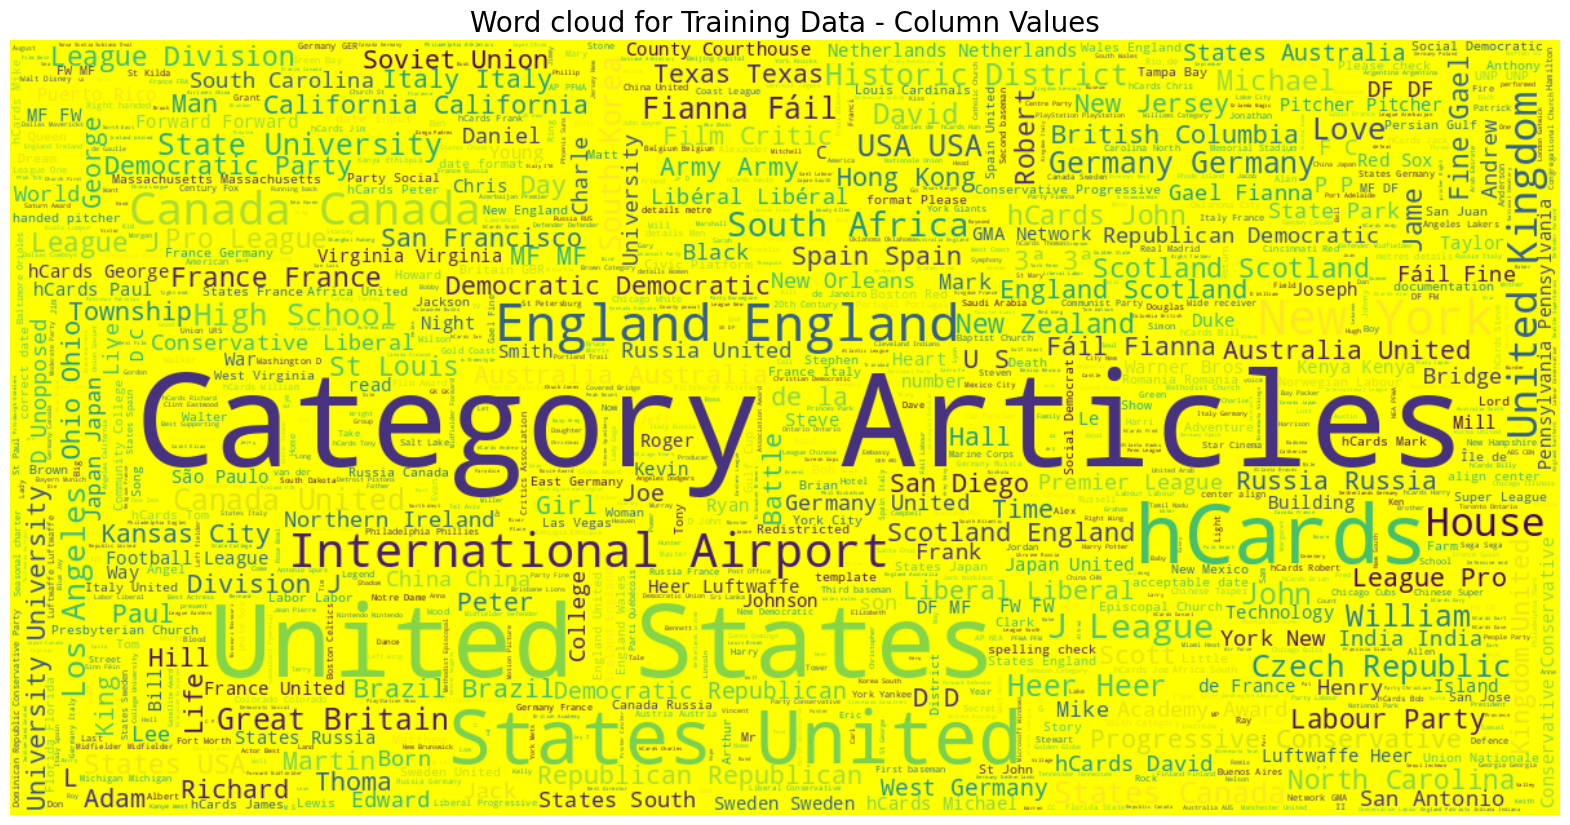

In [ ]:
# WordCloud

train_data_ex = train_df['data']
train_data_ex_string = ' '.join(train_data_ex)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000, width=1200, height=600,background_color="yellow",stopwords=STOPWORDS).generate(train_data_ex_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for Training Data - Column Values',fontsize = 20)
plt.show()


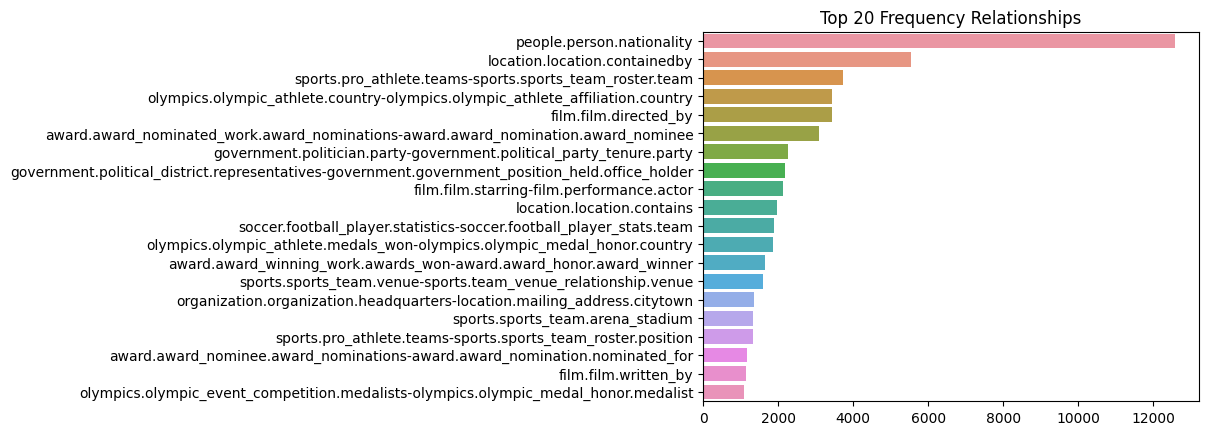

In [ ]:
# Frequency Labels - Visualization

train_df_value_counts = pd.Series([x for item in train_df.labels for x in item]).value_counts()
sns.barplot(y=train_df_value_counts.head(20).index, x=train_df_value_counts.head(20).values)
plt.title('Top 20 Frequency Relationships')
plt.show()

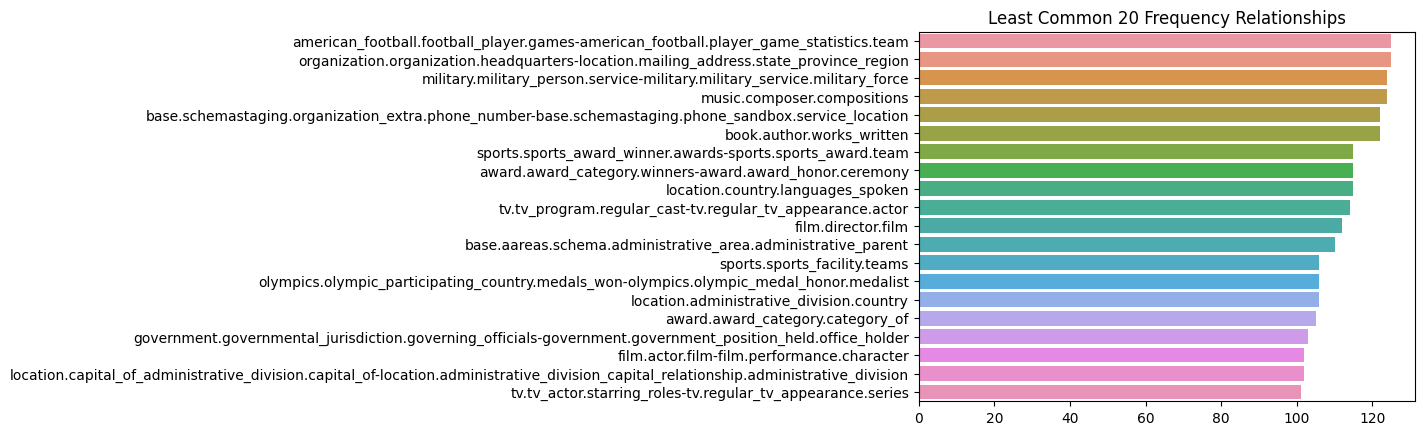

In [ ]:
# Frequency Labels - Visualization

train_df_value_counts = pd.Series([x for item in train_df.labels for x in item]).value_counts()
sns.barplot(y=train_df_value_counts.tail(20).index, x=train_df_value_counts.tail(20).values)
plt.title('Least Common 20 Frequency Relationships')
plt.show()

##### Tokenizer Length Distribution

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


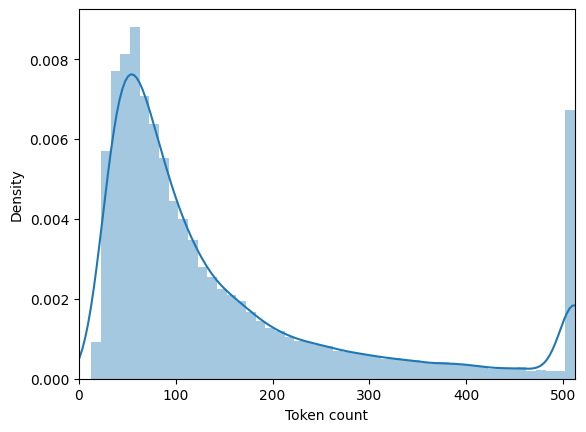

In [ ]:
tmp_tokenizer = config.TOKENIZER
token_lens = []

for txt in train_data_list:
  tokens = tmp_tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

#### T5 Training

##### Training Classes

In [ ]:
class T5Model(nn.Module):
    def __init__(self):
        super(T5Model, self).__init__()
        self.t5_model = T5ForConditionalGeneration.from_pretrained('google/mt5-small')

    def forward(
        self,
        input_ids, 
        attention_mask=None, 
        decoder_input_ids=None, 
        decoder_attention_mask=None, 
        lm_labels=None
        ):

        return self.t5_model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=lm_labels,
        )

##### Training Functions

In [ ]:
def convert_to_ohe(temp_list):
  '''
  Convert predicted list , with target values, to 
  one-hot-encoding according to the dict-key-values
  in order to calculate evaluation metrics
  NOTE that the number of classes is 121
  '''
  global_list = []
  for temp_batch in temp_list:
    base = 121*[0]
    temp_list_decomp= temp_batch.split(' ')
    for l in temp_list_decomp:
      if l is None or l.strip() =='' or 'extra_id' in l:
        continue
      else:
        temp = l.strip()
      if int(temp) in my_dict.keys():
        base[ int(temp) ] = 1
      else:
        continue
    global_list.append(base)
  return np.array(global_list)


In [ ]:
def val(model, val_dataloader, criterion):
    '''
    The function that is utilized to the validation phase
    with th respective dataloader
    '''
    
    val_loss = 0
    true, pred = [], []
    
    # set model.eval() every time during evaluation
    model.eval()
    
    for step, batch in enumerate(val_dataloader):
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)
    
        b_tgt_input_ids = batch['tgt_input_ids']
        lm_labels = b_tgt_input_ids.to(device)
        lm_labels[lm_labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        with torch.no_grad():
            # forward pass
            outputs = model(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask,
                lm_labels=lm_labels,
                decoder_attention_mask=b_tgt_attention_mask)
            loss = outputs[0]

            val_loss += loss.item()

            # get true 
            for true_id in b_tgt_input_ids:
                true_decoded = config.TOKENIZER.decode(true_id,skip_special_tokens=True).replace(",", "")
                true.append(true_decoded)

            # get pred (decoder generated textual label ids)
            pred_ids = model.t5_model.generate(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask
            )
            pred_ids = pred_ids.cpu().numpy()
            for pred_id in pred_ids:
                pred_decoded = config.TOKENIZER.decode(pred_id,skip_special_tokens=True).replace(",", "")
                pred.append(pred_decoded)


    # for Debugging
    # print('******'*8)
    # print(set(pred))
    # print('******'*8)

    true_ohe = convert_to_ohe(true)
    pred_ohe = convert_to_ohe(pred)

    avg_val_loss = val_loss / len(val_dataloader)
    print('Val loss:', avg_val_loss)
    print('Val accuracy:', accuracy_score(true_ohe, pred_ohe))

    val_micro_f1_score = f1_score(true_ohe, pred_ohe, average='micro')
    print('Val micro f1 score:', val_micro_f1_score)
    return val_micro_f1_score , avg_val_loss


def train(
    model,  
    train_dataloader, 
    criterion, 
    optimizer, 
    scheduler, 
    epoch
    ):
    '''
    The function that is utilized to the training phase
    with th respective dataloader
    '''
    
    train_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader, 
                                      desc='Epoch ' + str(epoch))):
        # set model.eval() every time during training
        model.train()
        
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)
    
        lm_labels = batch['tgt_input_ids'].to(device)
        lm_labels[lm_labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        # clear accumulated gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(input_ids=b_src_input_ids, 
                        attention_mask=b_src_attention_mask,
                        lm_labels=lm_labels,
                        decoder_attention_mask=b_tgt_attention_mask)
        loss = outputs[0]
        train_loss += loss.item()

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()
        
        # update scheduler
        scheduler.step()

    
    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss)
    return model, avg_train_loss

In [ ]:
# define the model 
# and move from CPU to GPU

device = config.DEVICE
model = T5Model()
model.to(device);

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


In [ ]:
# define the parameters to be optmized 
torch.manual_seed(config.SEED)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=config.LR)


if config.FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.001,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]
    optimizer = optim.AdamW(optimizer_parameters, lr=config.LR)

scheduler = get_constant_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0)

In [ ]:
avg_train_loss_list = []
avg_val_loss_list = []

# set the max val F1-score
max_val_micro_f1_score = float('-inf')

# run across the Epochs
for epoch in range(config.EPOCHS):
    model , avg_train_loss = train(model, train_dataloader, criterion, optimizer, scheduler, epoch)
    val_micro_f1_score , avg_val_loss = val(model, val_dataloader, criterion)
    avg_train_loss_list.append(avg_train_loss)
    avg_val_loss_list.append(avg_val_loss)
    if config.SAVE_BEST_ONLY:
        # save and overwrite only the best model
        # with the highest F1 score in validation
        if val_micro_f1_score > max_val_micro_f1_score:
            max_val_micro_f1_score = val_micro_f1_score
            best_model = copy.deepcopy(model)
            torch.save(best_model.state_dict(),config.OUTPUT_PATH)
            print(f'Best F1-score in Validation : {max_val_micro_f1_score}')


Epoch 0:   0%|          | 0/3935 [00:00<?, ?it/s]

Training loss: 6.061754469798814
Val loss: 2.2439064795480057
Val accuracy: 0.06436781609195402
Val micro f1 score: 0.061284619917501476
Best F1-score in Validation : 0.061284619917501476


Epoch 1:   0%|          | 0/3935 [00:00<?, ?it/s]

Training loss: 2.3972104318563034
Val loss: 2.021443200462005
Val accuracy: 0.06436781609195402
Val micro f1 score: 0.061284619917501476


Epoch 2:   0%|          | 0/3935 [00:00<?, ?it/s]

Training loss: 2.051724285364454
Val loss: 1.8312683473615086
Val accuracy: 0.06896551724137931
Val micro f1 score: 0.0734629738754665
Best F1-score in Validation : 0.0734629738754665


Epoch 3:   0%|          | 0/3935 [00:00<?, ?it/s]

Training loss: 1.70958730668549
Val loss: 1.4030570479876854
Val accuracy: 0.23264367816091955
Val micro f1 score: 0.2950257289879932
Best F1-score in Validation : 0.2950257289879932


Epoch 4:   0%|          | 0/3935 [00:00<?, ?it/s]

Training loss: 1.2994851455452179
Val loss: 1.0192808771834654
Val accuracy: 0.4335632183908046
Val micro f1 score: 0.4790589912671538
Best F1-score in Validation : 0.4790589912671538


Epoch 5:   0%|          | 0/3935 [00:00<?, ?it/s]

Training loss: 1.0116933892309439
Val loss: 0.7779459186336574
Val accuracy: 0.5255172413793103
Val micro f1 score: 0.5904590459045905
Best F1-score in Validation : 0.5904590459045905


Epoch 6:   0%|          | 0/3935 [00:00<?, ?it/s]

Training loss: 0.8341868294997016
Val loss: 0.6437497387694961
Val accuracy: 0.5977011494252874
Val micro f1 score: 0.6664298401420959
Best F1-score in Validation : 0.6664298401420959


Epoch 7:   0%|          | 0/3935 [00:00<?, ?it/s]

Training loss: 0.7154631987270891
Val loss: 0.5710683133014861
Val accuracy: 0.647816091954023
Val micro f1 score: 0.7203175748827136
Best F1-score in Validation : 0.7203175748827136


Epoch 8:   0%|          | 0/3935 [00:00<?, ?it/s]

Training loss: 0.6396765689837736
Val loss: 0.5265206689124599
Val accuracy: 0.6639080459770115
Val micro f1 score: 0.7358965145526409
Best F1-score in Validation : 0.7358965145526409


Epoch 9:   0%|          | 0/3935 [00:00<?, ?it/s]

Training loss: 0.5923255716375959
Val loss: 0.4885849829982309
Val accuracy: 0.6698850574712644
Val micro f1 score: 0.7445594006421691
Best F1-score in Validation : 0.7445594006421691


##### Training Graph of the model 

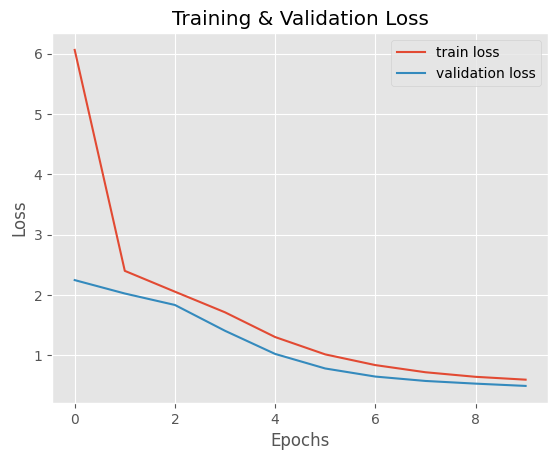

<Figure size 2000x2000 with 0 Axes>

In [ ]:
N = config.EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), avg_train_loss_list, label="train loss")
plt.plot(np.arange(0, N), avg_val_loss_list, label="validation loss")

plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.figure(figsize = (20,20))
plt.show()

##### Save the Model to Drive

In [ ]:
! cp -r /content/T5model_single_column_relationship.pt /content/drive/MyDrive/'Colab Notebooks'/Databases/T5_models

#### Loading the Model & Inference Examples

In [ ]:
load_T5_model = T5Model()
load_T5_model.to(config.DEVICE);
load_T5_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Databases/T5_models/T5model_single_column_relationship.pt'))

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


<All keys matched successfully>

In [ ]:
inference_val_dataloader = DataLoader(val_data, batch_size=1)

#### Inference Functions

In [ ]:
def convert_to_true_labels(inv_dict_labels):
  '''
  Convert from inv-dict labels to 
  true labels
  '''
  gen = []
  inv_dict_labels_list = inv_dict_labels.split(' ')
  for l in inv_dict_labels_list:
    if l is not None or l != '':
      if int(l) in my_dict.keys():
        gen.append(my_dict.get(int(l)))
  return ' & '.join(gen)

def inference_single_example(temp_model,temp_batch):
  '''
  With respect to a model and batch we make inference for a single example 
  '''

  b_src_input_ids = temp_batch['src_input_ids'].to(config.DEVICE)
  b_src_attention_mask = temp_batch['src_attention_mask'].to(config.DEVICE)
  pred_ids = temp_model.t5_model.generate(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask
            )

  pred_ids = pred_ids.cpu().numpy()
  for pred_id in pred_ids:
      pred_decoded = config.TOKENIZER.decode(pred_id,skip_special_tokens=True).replace(",", "")

  return pred_decoded

#### Inference Examples

In [ ]:
# Generate 2 random int for examples
random_list = random.sample(range(1, 100), 2)
print('Generate random indexes {} '.format(random_list))
print()

counter =0
for index, batch in enumerate(inference_val_dataloader):
  if index in random_list:
    print('Example {}'.format(counter))
    print('Data : {}'.format(config.TOKENIZER.decode(batch.get('src_input_ids')[0],skip_special_tokens=True)))
    inv_dict_labels = config.TOKENIZER.decode(batch.get('tgt_input_ids')[0],skip_special_tokens=True).replace(",", "")
    print('True Inv-Dict Labels : {}'.format(config.TOKENIZER.decode(batch.get('tgt_input_ids')[0],skip_special_tokens=True).replace(",", "")))
    print('True Labels : {}'.format(convert_to_true_labels(inv_dict_labels)))

    inference_ex_labels = inference_single_example(temp_model=load_T5_model,temp_batch=batch)
    print('Predicted Inv-Dict Labels : {}'.format(inference_ex_labels))
    print('Predicted Labels : {}'.format(convert_to_true_labels(inference_ex_labels)))

    print()
    counter = counter +1

Generate random indexes [38, 4] 

Example 0
Data : multilabel classification: el aaiún gustavia jamestown basseterre marigot castries saint-pierre kingstown apia san marino são tomé riyadh dakar belgrade victoria freetown singapore city philipsburg bratislava ljubljana honiara mogadishu hargeisa pretoria ( administrative capital ), cape town ( legislative capital ), bloemfontein, ( judicial capital ) seoul juba tskhinval madrid sri jayawardenapura kotte khartoum paramaribo longyearbyen mbabane stockholm bern damascus french english english french english french english english samoan italian portuguese arabic ( arabic script ) french serbian seychellois creole french english english malay english mandarin
True Inv-Dict Labels : 63
True Labels : location.country.official_language
Predicted Inv-Dict Labels : 62 63
Predicted Labels : location.country.languages_spoken & location.country.official_language

Example 1
Data : multilabel classification: jorge guillén jorge luis borges octavio p